## Predicting Store Sales using Machine Learning

In this notebook, we're going to go through an example machine learning project with the goal of predicting 
store sales.

## 1. Problem definition

> How well can we predict the future store sales given its past sales data?

## 2. Data

The data is downloaded from the Kaggle Store Sales - Time Series Forecasting competition: https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data

There are 6 main datasets.

## 3. Features: time-step feature and lag feature

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression

plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

In [ ]:
data_dir = Path('../input/ts-course-data/')
comp_dir = Path('../input/')

book_sales = pd.read_csv('store-sales-time-series-forecasting/book_sales.csv',
    index_col='Date',
    parse_dates=['Date'],
).drop('Paperback', axis=1)
book_sales['Time'] = np.arange(len(book_sales.index))
book_sales['Lag_1'] = book_sales['Hardcover'].shift(1)
book_sales = book_sales.reindex(columns=['Hardcover', 'Time', 'Lag_1'])

ar = pd.read_csv(data_dir / 'ar.csv')



In [3]:
dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}

store_sales = pd.read_csv('store-sales-time-series-forecasting/train.csv',
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']

In [4]:
average_sales.head()

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911148
2013-01-05    267.873230
Freq: D, Name: sales, dtype: float32

### Fit a time-step feature

In [5]:
df = average_sales.to_frame()

# Create a time dummy
time = np.arange(len(df.index))

df['time'] = time 

# Create training data
X = df.loc[:, ['time']]  # features
y = df.loc[:, 'sales']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

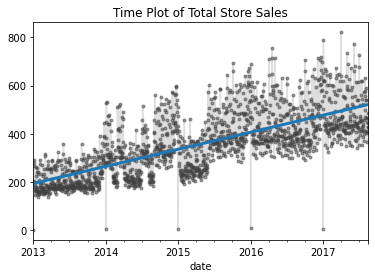

In [8]:
ax = y.plot(**plot_params, alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Total Store Sales');

### Fit a lag feature

In [9]:
df = average_sales.to_frame()

# Create a lag feature from the target 'sales'
lag_1 = df['sales'].shift(1)

df['lag_1'] = lag_1  # add to dataframe

X = df.loc[:, ['lag_1']].dropna()  # features
y = df.loc[:, 'sales']  # target
y, X = y.align(X, join='inner')  # drop corresponding values in target

# Create a LinearRegression instance and fit it to X and y.
model = LinearRegression().fit(X, y)

# Create Store the fitted values as a time series with
# the same time index as the training data
y_pred = pd.Series(model.predict(X), index=X.index)

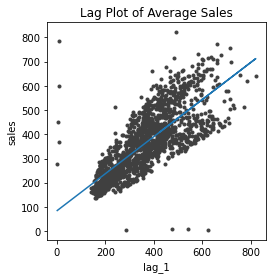

In [10]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales');

## 4. Seasonality

In [11]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [12]:
holidays_events = pd.read_csv("store-sales-time-series-forecasting/holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

In [15]:
holidays_events.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [13]:
store_sales = pd.read_csv("store-sales-time-series-forecasting/train.csv",
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)

In [14]:
store_sales.head()

,date,store_nbr,family,sales
0,2013-01-01,1,AUTOMOTIVE,0.0
1,2013-01-01,1,BABY CARE,0.0
2,2013-01-01,1,BEAUTY,0.0
3,2013-01-01,1,BEVERAGES,0.0
4,2013-01-01,1,BOOKS,0.0


In [16]:
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

In [17]:
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

In [19]:
average_sales.head()

date
2017-01-01      6.780303
2017-01-02    786.928406
2017-01-03    619.740234
2017-01-04    555.608032
2017-01-05    436.375397
Freq: D, Name: sales, dtype: float32

In [21]:
# define two functions: seasonal_plot and plot_periodogram
import seaborn as sns

def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

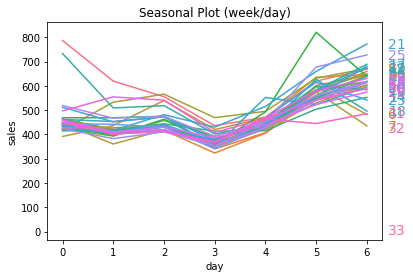

In [22]:
X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
seasonal_plot(X, y='sales', period='week', freq='day');

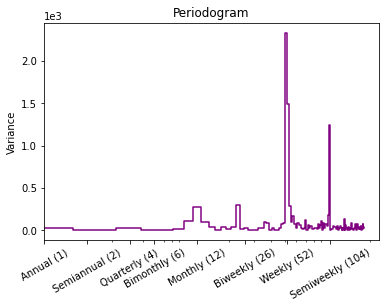

In [23]:
plot_periodogram(average_sales);

### (1) Determine seasonality

Both the seasonal plot and the periodogram suggest a **strong weekly seasonality**. 

From the periodogram, it appears there may be some **monthly** and **biweekly** components as well. In fact, the notes to the Store Sales dataset say wages in the public sector are paid out biweekly, on the 15th and last day of the month -- a possible origin for these seasons.

### (2) Create seasonal features
Use **DeterministicProcess** and **CalendarFourier** to create:

* indicators for weekly seasons and
* Fourier features of order 4 for monthly seasons.

In [24]:
y = average_sales.copy()

fourier = CalendarFourier(freq="M", order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,         
    additional_terms=[fourier], 
    drop=True,
)
X = dp.in_sample() 

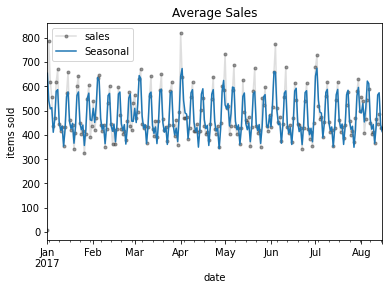

In [25]:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

Removing from a series its trend or seasons is called **detrending** or **deseasonalizing** the series.

Look at the periodogram of the deseasonalized series.

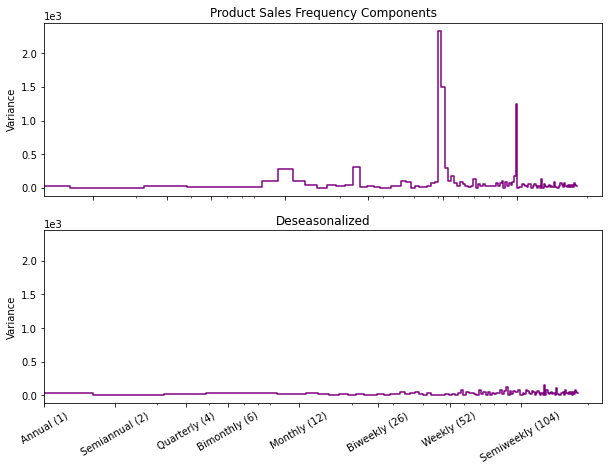

In [26]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

### (3) Check for remaining seasonality

The periodogram for the deseasonalized series lacks any large values. By comparing it to the periodogram for the original series, we can see that our model was able to capture the seasonal variation in Average Sales.

### (4) Seasonality for holidays

The Store Sales dataset includes a table of Ecuadorian holidays.

In [27]:
# National and regional holidays in the training set
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

display(holidays)

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo
2017-05-13,Dia de la Madre-1
2017-05-14,Dia de la Madre


From a plot of the deseasonalized Average Sales, it appears these holidays could have some predictive power.

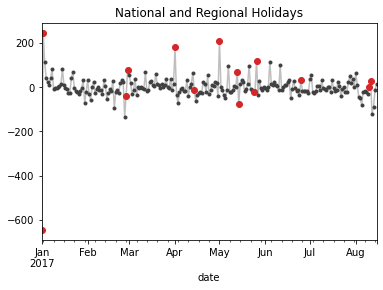

In [28]:
ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3')
ax.set_title('National and Regional Holidays');

### (5) Create holiday features

In [ ]:
# Scikit-learn solution
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)

X_holidays = pd.DataFrame(
    ohe.fit_transform(holidays),
    index=holidays.index,
    columns=holidays.description.unique(),
)

In [29]:
# Pandas solution
X_holidays = pd.get_dummies(holidays)

In [30]:
# Join to training data
X2 = X.join(X_holidays, on='date').fillna(0.0)

In [31]:
X2.head()

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,description_Dia de la Madre-1,description_Dia del Trabajo,description_Primer Grito de Independencia,description_Primer dia del ano,description_Provincializacion de Cotopaxi,description_Provincializacion de Imbabura,description_Traslado Batalla de Pichincha,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-02,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2017-01-03,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-04,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01-05,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Fit the seasonal model with holiday features added

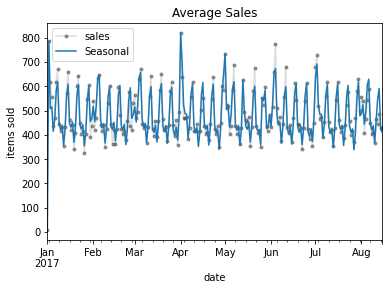

In [32]:
model = LinearRegression().fit(X2, y)
y_pred = pd.Series(
    model.predict(X2),
    index=X2.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X2), index=X2.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

### (6). New seasonal model for the competition

creates a seasonal model of the kind for the full Store Sales dataset with all 1800 time series

In [33]:
y = store_sales.unstack(['store_nbr', 'family']).loc["2017"]

# Create training data
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X['NewYear'] = (X.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

In [34]:
STORE_NBR = '1'  # 1 - 54
FAMILY = 'PRODUCE'
# Uncomment to see a list of product families
display(store_sales.index.get_level_values('family').unique())

CategoricalIndex(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
                  'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI',
                  'EGGS', 'FROZEN FOODS', 'GROCERY I', 'GROCERY II',
                  'HARDWARE', 'HOME AND KITCHEN I', 'HOME AND KITCHEN II',
                  'HOME APPLIANCES', 'HOME CARE', 'LADIESWEAR',
                  'LAWN AND GARDEN', 'LINGERIE', 'LIQUOR,WINE,BEER',
                  'MAGAZINES', 'MEATS', 'PERSONAL CARE', 'PET SUPPLIES',
                  'PLAYERS AND ELECTRONICS', 'POULTRY', 'PREPARED FOODS',
                  'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES', 'SEAFOOD'],
                 categories=['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS', 'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', ...], ordered=False, name='family', dtype='category')

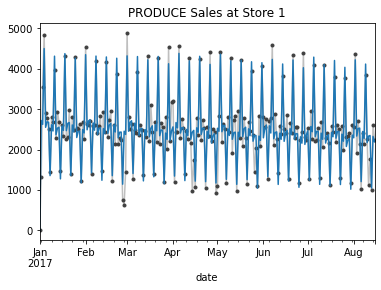

In [35]:
ax = y.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(**plot_params)
ax = y_pred.loc(axis=1)['sales', STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

### (7) Make predictions

Now load the test data, create a feature set for the forecast period, and then create the submission file `submission.csv`.

In [36]:
df_test = pd.read_csv('store-sales-time-series-forecasting/test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

# Create features for test set
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'
X_test['NewYear'] = (X_test.index.dayofyear == 1)


y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit.to_csv('submission.csv', index=False)

## 5. Seriel Dependence

In [3]:
store_sales = pd.read_csv('store-sales-time-series-forecasting/train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

In [4]:
store_sales.head()

sales  onpromotion
store_nbr family     date                          
1         AUTOMOTIVE 2013-01-01    0.0            0
                     2013-01-02    2.0            0
                     2013-01-03    3.0            0
                     2013-01-04    3.0            0
                     2013-01-05    5.0            0

In [5]:
family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean() 
    .unstack('family')
    .loc['2017', ['sales', 'onpromotion']]
)

In [6]:
family_sales.head()

sales                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-01   0.092593  0.037037   0.055556    74.222221  0.000000   
2017-01-02  11.481482  0.259259  11.648149  6208.055664  0.481481   
2017-01-03   8.296296  0.296296   7.185185  4507.814941  0.814815   
2017-01-04   6.833333  0.333333   6.888889  3911.833252  0.759259   
2017-01-05   6.333333  0.351852   5.925926  3258.796387  0.407407   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-01     9.084685    0.129630     7.500000    11.518518    3.629167   
2017-01-02   844.836304   14.203704  2233.648193  1545.000000  539.114807   
2017-01-03   665.124084   10.629630  1711.907349  1204.203735  404.300079   
2017-01-04   594.160583   11.185185  1508.036987  1107.796265  309.397675   
2017-01-05   495.511597   12.444445  1241.833374   829.277771  260.776489   

            ... onpromotion                                       \
family      ...   MAGAZINES     MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                    
2017-01-01  ...         0.0  0.018519      0.111111     0.018519   
2017-01-02  ...         0.0  0.462963     10.592593     0.537037   
2017-01-03  ...         0.0  0.481481      9.722222     0.444444   
2017-01-04  ...         0.0  0.370370     12.037037     0.444444   
2017-01-05  ...         0.0  8.981481      5.666667     0.000000   

                                                                         \
family     PLAYERS AND ELECTRONICS   POULTRY PREPARED FOODS     PRODUCE   
date                                                                      
2017-01-01                     0.0  0.000000       0.037037    0.129630   
2017-01-02                     0.0  0.259259       1.166667    5.629630   
2017-01-03                     0.0  0.388889       1.351852   56.296296   
2017-01-04                     0.0  0.296296       5.444444  101.277778   
2017-01-05                     0.0  0.296296       0.907407    5.018519   

                                                 
family     SCHOOL AND OFFICE SUPPLIES   SEAFOOD  
date                                             
2017-01-01                        0.0  0.000000  
2017-01-02                        0.0  0.407407  
2017-01-03                        0.0  0.407407  
2017-01-04                        0.0  0.333333  
2017-01-05                        0.0  0.444444  

[5 rows x 66 columns]

In [19]:
family_sales

sales                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-01   0.092593  0.037037   0.055556    74.222221  0.000000   
2017-01-02  11.481482  0.259259  11.648149  6208.055664  0.481481   
2017-01-03   8.296296  0.296296   7.185185  4507.814941  0.814815   
2017-01-04   6.833333  0.333333   6.888889  3911.833252  0.759259   
2017-01-05   6.333333  0.351852   5.925926  3258.796387  0.407407   
...               ...       ...        ...          ...       ...   
2017-08-11   8.166667  0.129630   6.500000  3502.055664  0.000000   
2017-08-12   7.462963  0.055556   6.833333  3376.259277  0.000000   
2017-08-13   8.907408  0.166667   8.018518  3747.296387  0.018519   
2017-08-14   5.407407  0.166667   6.240741  3237.629639  0.000000   
2017-08-15   6.240741  0.148148   6.277778  3162.462891  0.000000   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-01     9.084685    0.129630     7.500000    11.518518    3.629167   
2017-01-02   844.836304   14.203704  2233.648193  1545.000000  539.114807   
2017-01-03   665.124084   10.629630  1711.907349  1204.203735  404.300079   
2017-01-04   594.160583   11.185185  1508.036987  1107.796265  309.397675   
2017-01-05   495.511597   12.444445  1241.833374   829.277771  260.776489   
...                 ...         ...          ...          ...         ...   
2017-08-11   522.305298   16.111111  1031.148193   831.648132  345.934967   
2017-08-12   507.473114   15.722222  1072.870361   793.592590  290.553589   
2017-08-13   615.976990   10.074074  1143.648193   928.000000  325.801361   
2017-08-14   518.564026   11.000000  1019.111084   797.222229  271.532227   
2017-08-15   539.966553   11.055555  1082.851807   753.833313  276.582458   

            ... onpromotion                                        \
family      ...   MAGAZINES      MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                     
2017-01-01  ...         0.0   0.018519      0.111111     0.018519   
2017-01-02  ...         0.0   0.462963     10.592593     0.537037   
2017-01-03  ...         0.0   0.481481      9.722222     0.444444   
2017-01-04  ...         0.0   0.370370     12.037037     0.444444   
2017-01-05  ...         0.0   8.981481      5.666667     0.000000   
...         ...         ...        ...           ...          ...   
2017-08-11  ...         0.0  22.925926      9.000000     0.000000   
2017-08-12  ...         0.0   0.000000      8.703704     0.000000   
2017-08-13  ...         0.0   0.000000      9.240741     0.000000   
2017-08-14  ...         0.0   0.000000      8.722222     0.000000   
2017-08-15  ...         0.0   0.000000      8.814815     0.000000   

                                                                          \
family     PLAYERS AND ELECTRONICS    POULTRY PREPARED FOODS     PRODUCE   
date                                                                       
2017-01-01                0.000000   0.000000       0.037037    0.129630   
2017-01-02                0.000000   0.259259       1.166667    5.629630   
2017-01-03                0.000000   0.388889       1.351852   56.296296   
2017-01-04                0.000000   0.296296       5.444444  101.277778   
2017-01-05                0.000000   0.296296       0.907407    5.018519   
...                            ...        ...            ...         ...   
2017-08-11                0.000000  27.407407       0.537037    6.000000   
2017-08-12                0.018519   0.111111       0.277778    6.000000   
2017-08-13                0.000000   0.185185       0.222222    5.907407   
2017-08-14                0.000000   0.129630       0.148148    6.018519   
2017-08-15     

In [10]:
family_sales.columns

MultiIndex([(      'sales',                 'AUTOMOTIVE'),
            (      'sales',                  'BABY CARE'),
            (      'sales',                     'BEAUTY'),
            (      'sales',                  'BEVERAGES'),
            (      'sales',                      'BOOKS'),
            (      'sales',               'BREAD/BAKERY'),
            (      'sales',                'CELEBRATION'),
            (      'sales',                   'CLEANING'),
            (      'sales',                      'DAIRY'),
            (      'sales',                       'DELI'),
            (      'sales',                       'EGGS'),
            (      'sales',               'FROZEN FOODS'),
            (      'sales',                  'GROCERY I'),
            (      'sales',                 'GROCERY II'),
            (      'sales',                   'HARDWARE'),
            (      'sales',         'HOME AND KITCHEN I'),
            (      'sales',        'HOME AND KITCHEN II'

In [14]:
autoSales = family_sales.loc(axis=1)['sales', 'AUTOMOTIVE']
autoSales.head()

date
2017-01-01     0.092593
2017-01-02    11.481482
2017-01-03     8.296296
2017-01-04     6.833333
2017-01-05     6.333333
Freq: D, Name: (sales, AUTOMOTIVE), dtype: float32

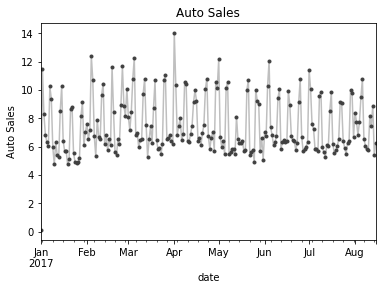

In [15]:
ax = autoSales.plot(title='Auto Sales', **plot_params)
_ = ax.set(ylabel="Auto Sales")

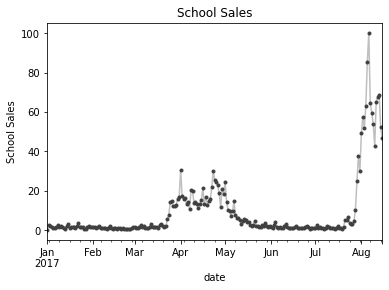

In [16]:
schoolSales = family_sales.loc(axis=1)['sales', 'SCHOOL AND OFFICE SUPPLIES']
ax = schoolSales.plot(title='School Sales', **plot_params)
_ = ax.set(ylabel="School Sales")

Not every product family has sales showing cyclic behavior, and neither does the series of average sales. Sales of school and office supplies, however, show **patterns of growth and decay** not well characterized by trend or seasons. In this question and the next, you'll model cycles in sales of school and office supplies using lag features.

Trend and seasonality will both create serial dependence that shows up in correlograms and lag plots. To isolate any purely cyclic behavior, we'll start by **deseasonalizing the series**. Use the code in the next cell to deseasonalize Supply Sales. We'll store the result in a variable `y_deseason`.

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

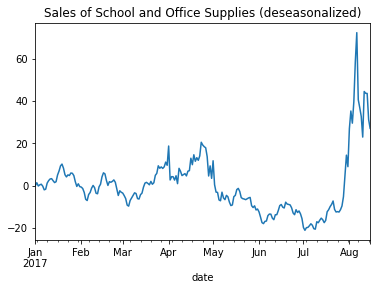

In [9]:
supply_sales = family_sales.loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES']
y = supply_sales.loc[:, 'sales'].squeeze()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X_time = dp.in_sample()
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X_time, y)
y_deseason = y - model.predict(X_time)
y_deseason.name = 'sales_deseasoned'

ax = y_deseason.plot()
ax.set_title("Sales of School and Office Supplies (deseasonalized)");

Does this deseasonalized series show cyclic patterns? To confirm our intuition, we can try to isolate cyclic behavior using a **moving-average plot** just like we did with trend. The idea is to choose a window long enough to smooth over short-term seasonality, but short enough to still preserve the cycles.

### (1) Plotting cycles

Create a seven-day moving average from `y`, the series of supply sales. Use a centered window, but don't set the min_periods argument.

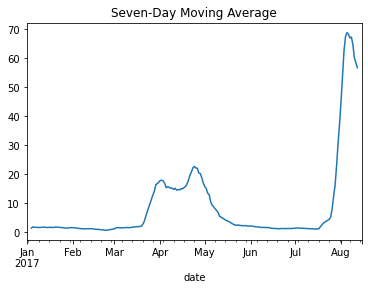

In [20]:
y_ma = y.rolling(
    window=7,       # 7-day window
    center=True,      # puts the average at the center of the window
).mean() 


# Plot
ax = y_ma.plot()
ax.set_title("Seven-Day Moving Average");

We can see that the moving average plot resembles the plot of the deseasonalized series. In both, we can see cyclic behavior indicated.

-------------------------------------------------------------------------------

Let's examine our deseasonalized series for serial dependence. Take a look at the partial autocorrelation correlogram and lag plot.

In [33]:
# define lag plots
def lagplot(x, y=None, shift=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(shift)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    title = f"Lag {shift}" if shift > 0 else f"Lead {shift}"
    ax.set(title=f"Lag {shift}", xlabel=x_.name, ylabel=y_.name)
    return ax

def plot_lags(x,
              y=None,
              lags=6,
              leads=None,
              nrows=1,
              lagplot_kwargs={},
              **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    orig = leads is not None
    leads = leads or 0
    kwargs.setdefault('ncols', math.ceil((lags + orig + leads) / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        k -= leads + orig
        if k + 1 <= lags:
            ax = lagplot(x, y, shift=k + 1, ax=ax, **lagplot_kwargs)
            title = f"Lag {k + 1}" if k + 1 >= 0 else f"Lead {-k - 1}"
            ax.set_title(title, fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


C:\Users\zxy23\AppData\Roaming\Python\Python38\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


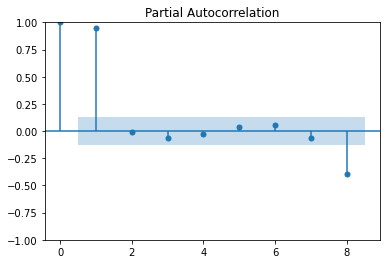

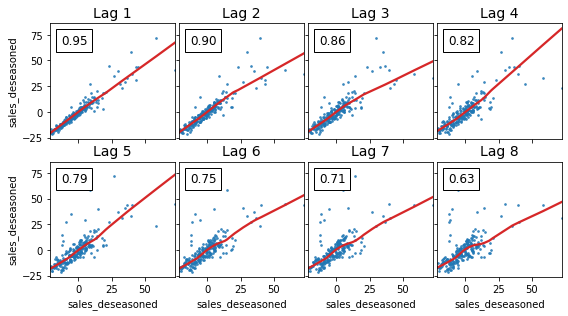

In [34]:
plot_pacf(y_deseason, lags=8);
plot_lags(y_deseason, lags=8, nrows=2);

### (2) Examine serial dependence

The correlogram indicates the first lag is likely to be significant, as well as possibly the eighth lag. The lag plot suggests the effect is mostly linear.

### (3) Examine leading indicator

Recall from the tutorial that a **leading indicator** is a series whose values at one time can be used to predict the target at a future time -- a leading indicator provides "advance notice" of changes in the target.

The competition dataset includes a time series that could potentially be useful as a leading indicator -- the `onpromotio` series, which contains the number of items on a special promotion that day. Since the company itself decides when to do a promotion, there's no worry about "lookahead leakage"; we could use Tuesday's `onpromotion` value to forecast sales on Monday, for instance.

Use the next cell to examine leading and lagging values for onpromotion plotted against sales of school and office supplies.

In [29]:
onpromotion = supply_sales.loc[:, 'onpromotion'].squeeze().rename('onpromotion')

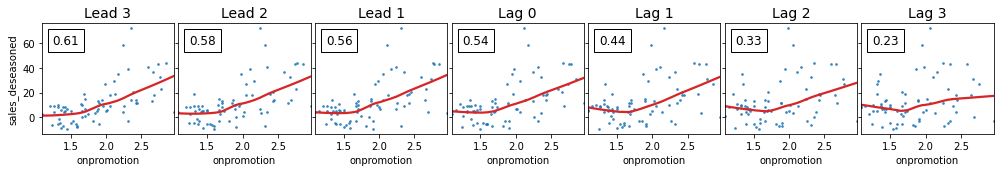

In [36]:
# Drop days without promotions
plot_lags(x=onpromotion.loc[onpromotion > 1], y=y_deseason.loc[onpromotion > 1], lags=3, leads=3, nrows=1);

The lag plot indicates that both leading and lagged values of `onpromotion` are correlated with supply sales. This suggests that both kinds of values could be useful as features. There may be some non-linear effects as well.

### (4) Create time series features

Create the leading features based on the previous cell.

In [37]:
def make_lags(ts, lags, lead_time=1, name='y'):
    return pd.concat(
        {
            f'{name}_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)


def make_leads(ts, leads, name='y'):
    return pd.concat(
        {f'{name}_lead_{i}': ts.shift(-i)
         for i in reversed(range(leads))},
        axis=1)

In [38]:
X_lags = make_lags(y_deseason, lags=1)

# Make features from `onpromotion`
# You may want to use `pd.concat`
X_promo = pd.concat([
    make_lags(onpromotion, lags=1),
    onpromotion,
    make_leads(onpromotion, leads=1),
], axis=1)

X = pd.concat([X_lags, X_promo], axis=1).dropna()
y, X = y.align(X, join='inner')

Make predictions from the resulting model.

Training RMSLE: 0.83417
Validation RMSLE: 1.17316


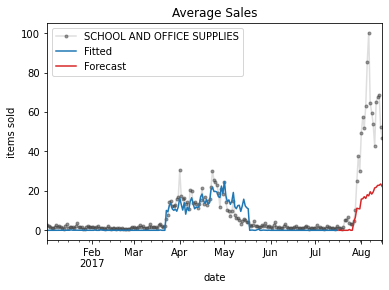

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=30, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fit.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred.plot(ax=ax, label="Forecast", color='C3')
ax.legend();

Winners of Kaggle forecasting competitions have often included **moving averages** and other rolling statistics in their feature sets. Such features seem to be especially useful when used with **GBDT algorithms** like `XGBoost`. (GBDT: Gradient Boosting Decision Trees)

Previously we learned how to compute moving averages to estimate trends. Computing rolling statistics to be used as features is similar except we need to take care to **avoid lookahead leakage**. First, the result should be set at the right end of the window instead of the center -- that is, we should use `center=False` (the default) in the rolling method. Second, the target should be lagged a step.

### (5) Create statistical features
Create the following features:

* 14-day rolling median (median) of lagged target
* 7-day rolling standard deviation (std) of lagged target
* 7-day sum (sum) of items "on promotion", with centered window

In [40]:
y_lag = supply_sales.loc[:, 'sales'].shift(1)
onpromo = supply_sales.loc[:, 'onpromotion']

# 28-day mean of lagged target
mean_7 = y_lag.rolling(7).mean()
# 14-day median of lagged target
median_14 = y_lag.rolling(14).median()
# 7-day rolling standard deviation of lagged target
std_7 = y_lag.rolling(7).std()
# 7-day sum of promotions with centered window
promo_7 = onpromo.rolling(7, center = True).sum()

Check out the Pandas `Window` documentation for more statistics you can compute. Also try "exponential weighted" windows by using `ewm` in place of `rolling`; exponential decay is often a more realistic representation of how effects propagate over time.

## 6. Hybrid Models

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import DeterministicProcess
from xgboost import XGBRegressor

In [2]:
store_sales = pd.read_csv('store-sales-time-series-forecasting/train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

In [3]:
family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

In [4]:
family_sales.head()

sales                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-01   0.092593  0.037037   0.055556    74.222221  0.000000   
2017-01-02  11.481482  0.259259  11.648149  6208.055664  0.481481   
2017-01-03   8.296296  0.296296   7.185185  4507.814941  0.814815   
2017-01-04   6.833333  0.333333   6.888889  3911.833252  0.759259   
2017-01-05   6.333333  0.351852   5.925926  3258.796387  0.407407   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-01     9.084685    0.129630     7.500000    11.518518    3.629167   
2017-01-02   844.836304   14.203704  2233.648193  1545.000000  539.114807   
2017-01-03   665.124084   10.629630  1711.907349  1204.203735  404.300079   
2017-01-04   594.160583   11.185185  1508.036987  1107.796265  309.397675   
2017-01-05   495.511597   12.444445  1241.833374   829.277771  260.776489   

            ... onpromotion                                       \
family      ...   MAGAZINES     MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                    
2017-01-01  ...         0.0  0.018519      0.111111     0.018519   
2017-01-02  ...         0.0  0.462963     10.592593     0.537037   
2017-01-03  ...         0.0  0.481481      9.722222     0.444444   
2017-01-04  ...         0.0  0.370370     12.037037     0.444444   
2017-01-05  ...         0.0  8.981481      5.666667     0.000000   

                                                                         \
family     PLAYERS AND ELECTRONICS   POULTRY PREPARED FOODS     PRODUCE   
date                                                                      
2017-01-01                     0.0  0.000000       0.037037    0.129630   
2017-01-02                     0.0  0.259259       1.166667    5.629630   
2017-01-03                     0.0  0.388889       1.351852   56.296296   
2017-01-04                     0.0  0.296296       5.444444  101.277778   
2017-01-05                     0.0  0.296296       0.907407    5.018519   

                                                 
family     SCHOOL AND OFFICE SUPPLIES   SEAFOOD  
date                                             
2017-01-01                        0.0  0.000000  
2017-01-02                        0.0  0.407407  
2017-01-03                        0.0  0.407407  
2017-01-04                        0.0  0.333333  
2017-01-05                        0.0  0.444444  

[5 rows x 66 columns]

In the next two questions, you'll create a **boosted hybrid** for the Store Sales dataset by implementing a new Python class. Run the next cell to create the initial class definition. You'll add `fit` and `predict` methods to give it a scikit-learn like interface.

In [5]:
# You'll add fit and predict methods to this minimal class
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

### (1) Define fit method for boosted hybrid
Complete the `fit` definition for the BoostedHybrid class. 

In [6]:
def fit(self, X_1, X_2, y):
    # Train model_1
    self.model_1.fit(X_1, y)

    # Make predictions
    y_fit = pd.DataFrame(
        self.model_1.predict(X_1), 
        index=X_1.index, columns=y.columns,
    )

    # Compute residuals
    y_resid = y - y_fit
    y_resid = y_resid.stack().squeeze() # wide to long

    # Train model_2 on residuals
    self.model_2.fit(X_2, y_resid)

    # Save column names for predict method
    self.y_columns = y.columns
    # Save data for question checking
    self.y_fit = y_fit
    self.y_resid = y_resid


# Add method to class
BoostedHybrid.fit = fit

### (2) Define predict method for boosted hybrid
Now define the `predict` method for the BoostedHybrid class. 

In [7]:
def predict(self, X_1, X_2):
    # Predict with model_1
    y_pred = pd.DataFrame(
        self.model_1.predict(X_1), 
        index=X_1.index, columns=self.y_columns,
    )
    y_pred = y_pred.stack().squeeze()  # wide to long

    # Add model_2 predictions to model_1 predictions
    y_pred += self.model_2.predict(X_2)

    return y_pred.unstack()


# Add method to class
BoostedHybrid.predict = predict

Now you're ready to use your new `BoostedHybrid` class to create a model for the Store Sales data.

In [8]:
# Target series
y = family_sales.loc[:, 'sales']

In [9]:
# X_1: Features for Linear Regression
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()

# X_2: Features for XGBoost
X_2 = family_sales.drop('sales', axis=1).stack()  # onpromotion feature

# Label encoding for 'family'
le = LabelEncoder()  # from sklearn.preprocessing
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])

# Label encoding for seasonality
X_2["day"] = X_2.index.day  # values are day of the month

### (3) Train boosted hybrid
Create the hybrid model by initializing a `BoostedHybrid` class with `LinearRegression()` and `XGBRegressor()` instances.

In [12]:
# Create model
model = BoostedHybrid(
    model_1=LinearRegression(),
    model_2=XGBRegressor(),
)
model.fit(X_1, X_2, y)

y_pred = model.predict(X_1, X_2)
y_pred = y_pred.clip(0.0)

Depending on your problem, you might want to use other hybrid combinations than the linear regression + XGBoost hybrid you've created in the previous cell.

In [13]:
# Model 1 (trend)
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Model 2
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

# Boosted Hybrid

# Try different combinations of the algorithms above
model = BoostedHybrid(
    model_1=Ridge(),
    model_2=KNeighborsRegressor(),
)

These are just some suggestions. You might discover other algorithms you like in the scikit-learn User Guide (https://scikit-learn.org/stable/supervised_learning.html).

Use the code in the next cell to see the predictions that hybrid makes.

C:\Users\zxy23\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:61: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()
C:\Users\zxy23\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:61: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


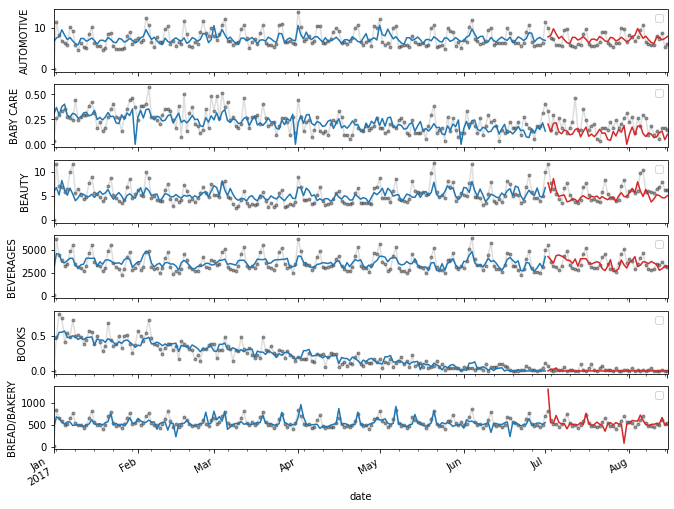

In [16]:
y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02" :]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

# Some of the algorithms above do best with certain kinds of
# preprocessing on the features (like standardization), but this is
# just a demo.
model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(
    subplots=True, sharex=True, figsize=(11, 9), **plot_params, alpha=0.5,
)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

### (4) Fit with different learning algorithms

## 7. Forecasting with Machine Learning

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

In [18]:
store_sales = pd.read_csv('store-sales-time-series-forecasting/train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

In [19]:
family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

In [20]:
test = pd.read_csv('store-sales-time-series-forecasting/test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
test['date'] = test.date.dt.to_period('D')
test = test.set_index(['store_nbr', 'family', 'date']).sort_index()

Consider the following three forecasting tasks:

* a. 3-step forecast using 4 lag features with a 2-step lead time
* b. 1-step forecast using 3 lag features with a 1-step lead time
* c. 3-step forecast using 4 lag features with a 1-step lead time

Run the next cell to see three datasets, each representing one of the tasks above.

In [24]:
def make_lags(ts, lags, lead_time=1, name='y'):
    return pd.concat(
        {
            f'{name}_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)


def make_leads(ts, leads, name='y'):
    return pd.concat(
        {f'{name}_lead_{i}': ts.shift(-i)
         for i in reversed(range(leads))},
        axis=1)


def make_multistep_target(ts, steps, reverse=False):
    shifts = reversed(range(steps)) if reverse else range(steps)
    return pd.concat({f'y_step_{i + 1}': ts.shift(-i) for i in shifts}, axis=1)

In [25]:
def create_multistep_example(n, steps, lags, lead_time=1):
    ts = pd.Series(
        np.arange(n),
        index=pd.period_range(start='2010', freq='A', periods=n, name='Year'),
        dtype=pd.Int8Dtype,
    )
    X = make_lags(ts, lags, lead_time)
    y = make_multistep_target(ts, steps, reverse=True)
    data = pd.concat({'Targets': y, 'Features': X}, axis=1)
    data = data.style.set_properties(['Targets'], **{'background-color': 'LavenderBlush'}) \
                     .set_properties(['Features'], **{'background-color': 'Lavender'})
    return data

def load_multistep_data():
    df1 = create_multistep_example(10, steps=1, lags=3, lead_time=1)
    df2 = create_multistep_example(10, steps=3, lags=4, lead_time=2)
    df3 = create_multistep_example(10, steps=3, lags=4, lead_time=1)
    return [df1, df2, df3]

In [27]:
import ipywidgets as widgets

In [28]:
datasets = load_multistep_data()

data_tabs = widgets.Tab([widgets.Output() for _ in enumerate(datasets)])
for i, df in enumerate(datasets):
    data_tabs.set_title(i, f'Dataset {i+1}')
    with data_tabs.children[i]:
        display(df)

display(data_tabs)

### (1). Match description to dataset

The number of forecasting steps is the number of columns under **Targets**. The number of lags is the number of columns under **Features**. The lead time is the smallest lag step possible.

* task_a = 2
* task_b = 1
* task_c = 3

Look at the time indexes of the training and test sets. From this information, can you identify the forecasting task for Store Sales?

In [29]:
print("Training Data", "\n" + "-" * 13 + "\n", store_sales)
print("\n")
print("Test Data", "\n" + "-" * 9 + "\n", test)

Training Data 
-------------
                                      sales  onpromotion
store_nbr family     date                              
1         AUTOMOTIVE 2013-01-01   0.000000            0
                     2013-01-02   2.000000            0
                     2013-01-03   3.000000            0
                     2013-01-04   3.000000            0
                     2013-01-05   5.000000            0
...                                    ...          ...
9         SEAFOOD    2017-08-11  23.830999            0
                     2017-08-12  16.859001            4
                     2017-08-13  20.000000            0
                     2017-08-14  17.000000            0
                     2017-08-15  16.000000            0

[3000888 rows x 2 columns]


Test Data 
---------
                                       id  onpromotion
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888            0
                     2017-08

### (2). Identify the forecasting task for Store Sales competition

Try to identify the **forecast origin** and the **forecast horizon**. How many steps are within the forecast horizon? What is the lead time for the forecast?

**Answer**:

The training set ends on `2017-08-15`, which gives us the forecast origin. The test set comprises the dates `2017-08-16` to `2017-08-31`, and this gives us the forecast horizon. There is one step between the origin and horizon, so we have a lead time of one day.

Put another way, we need a 16-step forecast with a 1-step lead time. We can use lags starting with lag 1, and we make the entire 16-step forecast using features from `2017-08-15`.

Previously, we saw how to create a multistep dataset for a single time series. Fortunately, we can use exactly the same procedure for datasets of multiple series.

### (3). Create multistep dataset for Store Sales

Create targets suitable for the Store Sales forecasting task. Use 4 days of lag features. Drop any missing values from both targets and features.

In [30]:
y = family_sales.loc[:, 'sales']

X = make_lags(y, lags=4).dropna()

y = make_multistep_target(y, steps=16).dropna()

y, X = y.align(X, join='inner', axis=0)

Now, we'll apply the **DirRec** strategy to the multiple time series of Store Sales.

Firstly, prepare the data for XGBoost.

In [31]:
le = LabelEncoder()
X = (X
    .stack('family')  # wide to long
    .reset_index('family')  # convert index to column
    .assign(family=lambda x: le.fit_transform(x.family))  # label encode
)
y = y.stack('family')  # wide to long

display(y)

y_step_1     y_step_2     y_step_3  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     6.333333     6.018518    10.259259   
           BABY CARE                      0.351852     0.277778     0.259259   
           BEAUTY                         5.925926     6.518518    10.037037   
           BEVERAGES                   3258.796387  3507.277832  4848.518555   
           BOOKS                          0.407407     0.537037     0.481481   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      364.955658   403.601349   377.313965   
           PREPARED FOODS                84.698647    87.836800    88.735962   
           PRODUCE                     2257.140625  2609.180176  3122.895752   
           SCHOOL AND OFFICE SUPPLIES    30.111111    49.333332    57.481480   
           SEAFOOD                       20.488333    20.346851    20.801037   

                                          y_step_4     y_step_5     y_step_6  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     9.388889     5.944445     4.777778   
           BABY CARE                      0.240741     0.444444     0.240741   
           BEAUTY                        11.611111     5.648148     6.500000   
           BEVERAGES                   5503.647949  3448.203613  3171.740723   
           BOOKS                          0.722222     0.500000     0.518519   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      316.436096   533.497070   416.454010   
           PREPARED FOODS                77.172997    91.886757   100.384964   
           PRODUCE                     1792.220947  2079.319580  2418.970215   
           SCHOOL AND OFFICE SUPPLIES    51.907406    63.222221    85.203705   
           SEAFOOD                       17.116297    25.553963    24.209518   

                                          y_step_7     y_step_8     y_step_9  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     6.314815     5.388889     5.240741   
           BABY CARE                      0.277778     0.296296     0.296296   
           BEAUTY                         5.277778     4.370370     4.703704   
           BEVERAGES                   3046.870361  2693.722168  3226.037109   
           BOOKS                          0.481481     0.388889     0.444444   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      464.596558   344.051727   313.780884   
           PREPARED FOODS               102.248146    86.627441    77.344131   
           PRODUCE                     2675.105713  2111.133545  2168.535400   
           SCHOOL AND OFFICE SUPPLIES   100.277779    64.407410    59.759258   
           SEAFOOD                       23.512852    18.419851    18.481131   

                                         y_step_10    y_step_11    y_step_12  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     8.500000    10.259259     6.407407   
           BABY CARE                      0.388889     0.425926     0.314815   
           BEAUTY                         7.777778     9.037037     5.648148   
           BEVERAGES                   4667.296387  5580.611328  3700.370361   
           BOOKS                          0.574074     0.555556     0.388889   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      305.270203   278.819855   468.857361   
           PREPARED FOODS                84.796539    78.791443    96.286926   
           PRODUCE                     2663.076172  1670.264893  2198.854492   
           SCHOOL AND OFFICE SUPPLIES  

### (4). Forecast with the DirRec strategy

Instatiate a model that applies the DirRec strategy to XGBoost.

In [32]:
from sklearn.multioutput import RegressorChain

model = RegressorChain(base_estimator=XGBRegressor())

In [33]:
# train the model
model.fit(X, y)

y_pred = pd.DataFrame(
    model.predict(X),
    index=y.index,
    columns=y.columns,
).clip(0.0)

In [35]:
def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

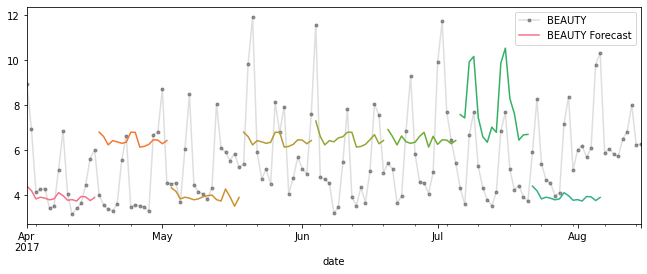

In [36]:
# see a sample of the 16-step predictions this model makes on the training data
FAMILY = 'BEAUTY'
START = '2017-04-01'
EVERY = 16

y_pred_ = y_pred.xs(FAMILY, level='family', axis=0).loc[START:]
y_ = family_sales.loc[START:, 'sales'].loc[:, FAMILY]

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax = y_.plot(**plot_params, ax=ax, alpha=0.5)
ax = plot_multistep(y_pred_, ax=ax, every=EVERY)
_ = ax.legend([FAMILY, FAMILY + ' Forecast'])

## 8. Next Steps

Congratulations! You've completed Kaggle's *Time Series* course. If you haven't already, join our companion competition: [Store Sales - Time Series Forecasting](https://www.kaggle.com/c/29781) and apply the skills you've learned.

For inspiration, check out Kaggle's previous forecasting competitions. Studying winning competition solutions is a great way to upgrade your skills.

- [**Corporación Favorita**](https://www.kaggle.com/c/favorita-grocery-sales-forecasting): the competition *Store Sales* is derived from.
- [**Rossmann Store Sales**](https://www.kaggle.com/c/rossmann-store-sales)
- [**Wikipedia Web Traffic**](https://www.kaggle.com/c/web-traffic-time-series-forecasting/)
- [**Walmart Store Sales**](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting)
- [**Walmart Sales in Stormy Weather**](https://www.kaggle.com/c/walmart-recruiting-sales-in-stormy-weather)
- [**M5 Forecasting - Accuracy**](https://www.kaggle.com/c/m5-forecasting-accuracy)

## 9. References

Here are some great resources you might like to consult for more on time series and forecasting. They all played a part in shaping this course:

- *Learnings from Kaggle's forecasting competitions*, an article by Casper Solheim Bojer and Jens Peder Meldgaard.
- *Forecasting: Principles and Practice*, a book by Rob J Hyndmann and George Athanasopoulos.
- *Practical Time Series Forecasting with R*, a book by Galit Shmueli and Kenneth C. Lichtendahl Jr.
- *Time Series Analysis and Its Applications*, a book by Robert H. Shumway and David S. Stoffer.
- *Machine learning strategies for time series forecasting*, an article by Gianluca Bontempi, Souhaib Ben Taieb, and Yann-Aël Le Borgne.
- *On the use of cross-validation for time series predictor evaluation*, an article by Christoph Bergmeir and José M. Benítez.